
# **<center><font style="color:rgb(100,109,254)">Human Action Detection</font> </center>**

<center>
<img src='https://drive.google.com/uc?export=download&id=1ucdFpzyVbzTa7kPYsJ2av-gRKgd84ICA'></center>

 <h2>Project Developers:</h2>
  <ul>
      <li>Swapnil Patil</li>
      <li>Devyani Ushir</li>
      <li>Komal Shinde</li>
      <li>Adity Vhanamane</li>
      
  </ul>



In [1]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy
!pip install -q moviepy
!apt install imagemagick
!pip install imageio==2.4.1

In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sn
from collections import deque
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

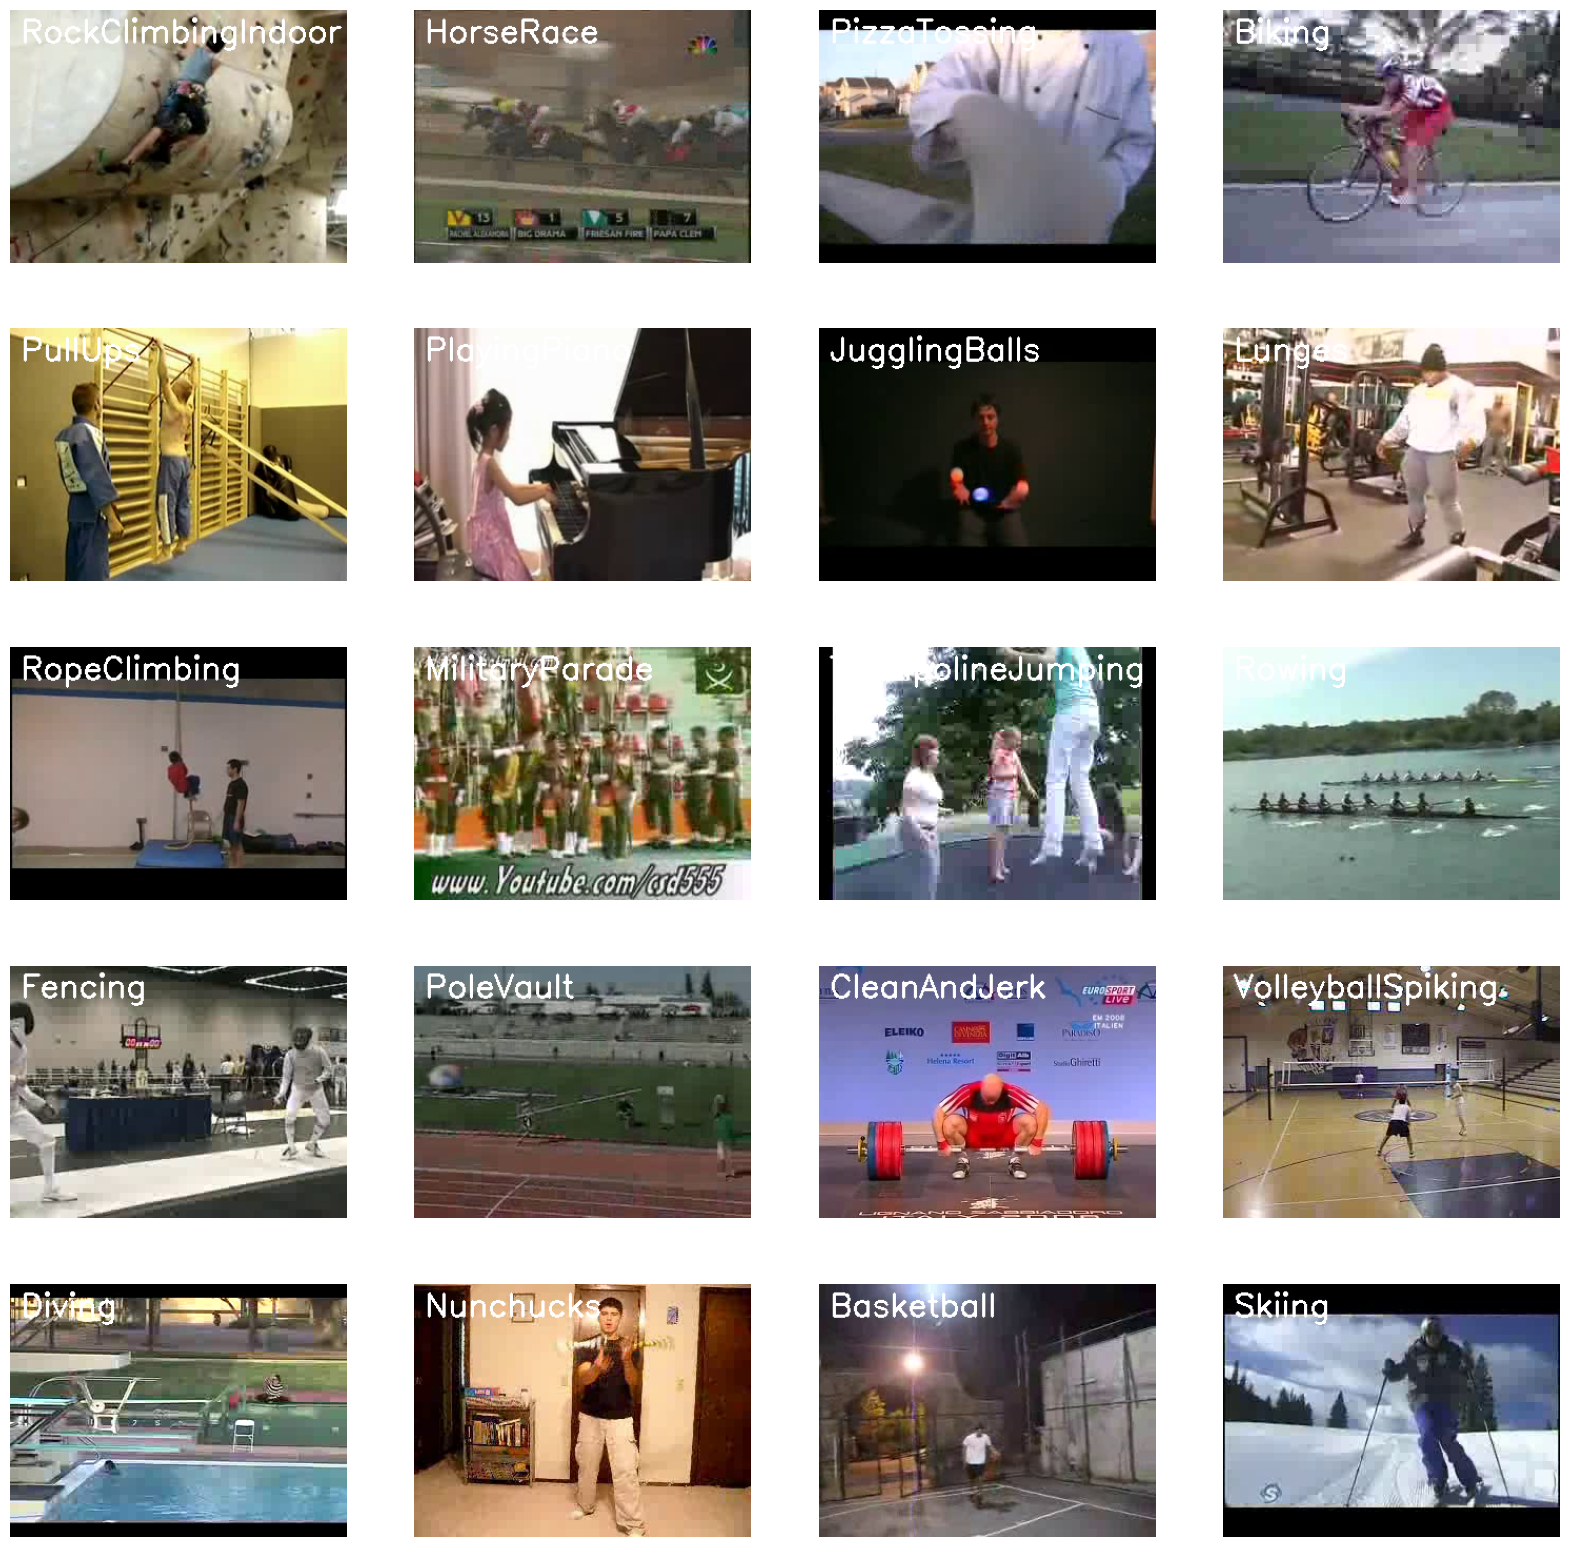

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","Basketball","Rowing"]

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: Basketball
Extracting Data of Class: Rowing


In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [12]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))



    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [13]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

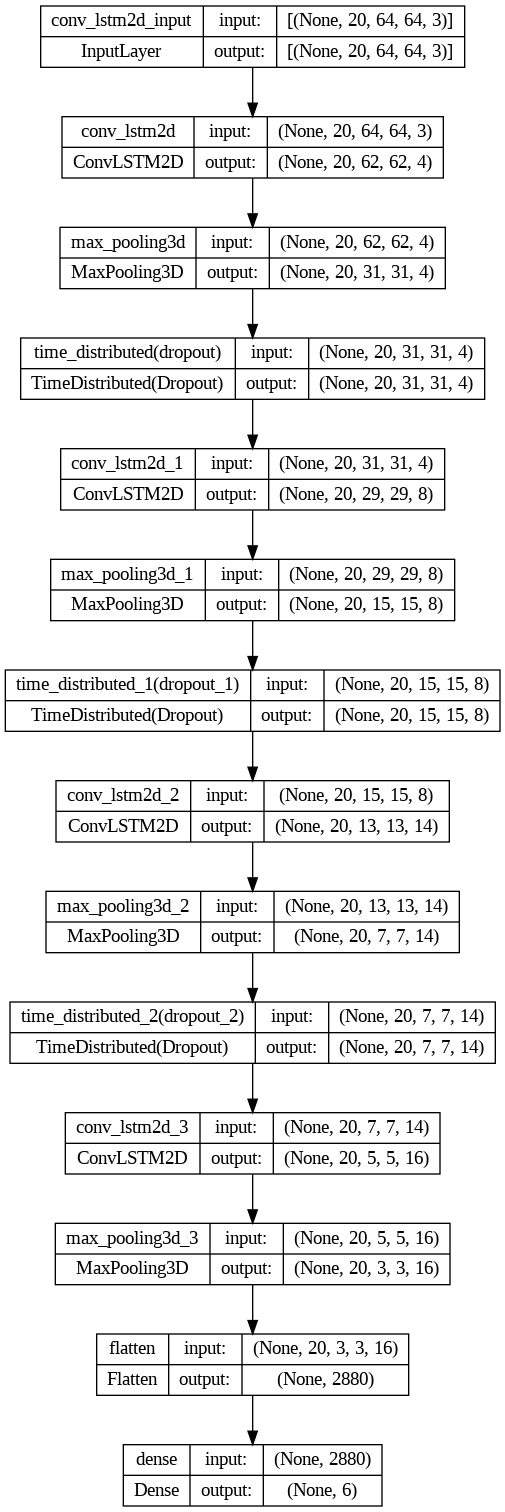

In [14]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [15]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs =70 , batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
114/114 [==============================] - 42s 229ms/step - loss: 1.7897 - accuracy: 0.1886 - val_loss: 1.7816 - val_accuracy: 0.1754
Epoch 2/70
114/114 [==============================] - 23s 205ms/step - loss: 1.6824 - accuracy: 0.3026 - val_loss: 1.6593 - val_accuracy: 0.3509
Epoch 3/70
114/114 [==============================] - 24s 209ms/step - loss: 1.3970 - accuracy: 0.4561 - val_loss: 1.2543 - val_accuracy: 0.4649
Epoch 4/70
114/114 [==============================] - 23s 206ms/step - loss: 1.0620 - accuracy: 0.5965 - val_loss: 1.0105 - val_accuracy: 0.6228
Epoch 5/70
114/114 [==============================] - 23s 205ms/step - loss: 0.8251 - accuracy: 0.6798 - val_loss: 0.9271 - val_accuracy: 0.6404
Epoch 6/70
114/114 [==============================] - 24s 207ms/step - loss: 0.7154 - accuracy: 0.7412 - val_loss: 0.8169 - val_accuracy: 0.6754
Epoch 7/70
114/114 [==============================] - 24s 206ms/step - loss: 0.5487 - accuracy: 0.7917 - val_loss: 0.7110 - val_ac

**<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [16]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 1s 125ms/step - loss: 0.8228 - accuracy: 0.7644


In [17]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

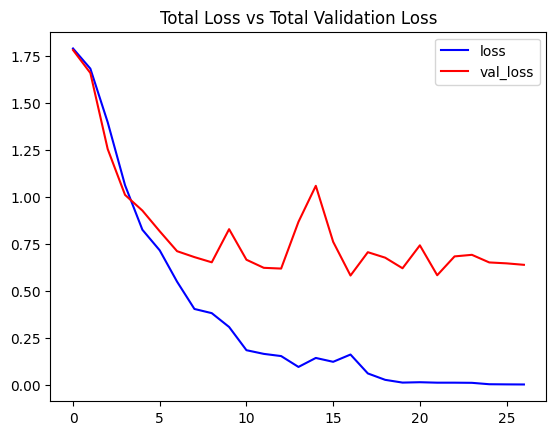

In [19]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

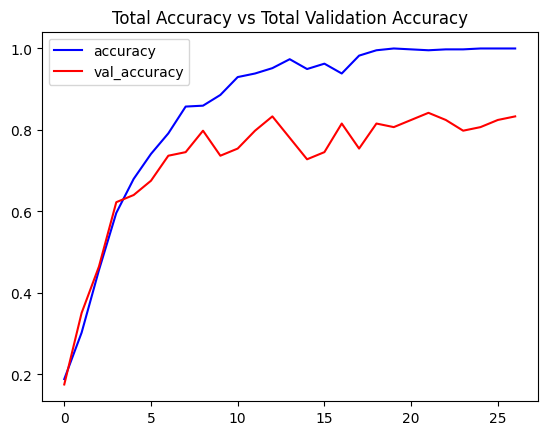

In [20]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**<font style="color:rgb(134,19,348)">Confusion Matrix Visualize</font>**

In [21]:
# Evaluate the confusion_marix.
convlstm_model.predict(np.expand_dims(features_test[0], axis=0)).round(2)

1/1 [==============================] - 1s 1s/step


array([[0., 0., 1., 0., 0., 0.]], dtype=float32)

In [22]:
y_test=np.argmax(labels_test,axis=-1)

In [23]:
labels_test[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [24]:
# predict the features_test data
y_pred = np.argmax(convlstm_model.predict(features_test),axis=1)
y_pred

6/6 [==============================] - 0s 72ms/step


array([2, 0, 2, 3, 2, 5, 0, 2, 4, 0, 4, 4, 2, 2, 3, 5, 4, 3, 3, 0, 3, 3,
       2, 2, 2, 3, 2, 3, 4, 0, 4, 0, 2, 2, 5, 2, 1, 1, 4, 5, 1, 3, 3, 0,
       3, 3, 4, 0, 0, 0, 3, 2, 2, 5, 3, 4, 5, 5, 2, 0, 2, 0, 1, 1, 2, 2,
       3, 1, 3, 2, 4, 2, 1, 2, 4, 4, 1, 3, 0, 1, 4, 2, 4, 4, 1, 2, 4, 0,
       4, 2, 2, 1, 2, 4, 0, 3, 5, 3, 3, 4, 5, 4, 1, 5, 2, 4, 5, 3, 5, 0,
       0, 4, 4, 2, 2, 4, 2, 0, 3, 2, 1, 1, 1, 3, 2, 4, 5, 3, 0, 2, 3, 0,
       0, 5, 3, 4, 0, 5, 4, 3, 4, 1, 5, 1, 2, 4, 1, 2, 3, 0, 2, 4, 3, 3,
       5, 1, 0, 5, 3, 3, 0, 4, 5, 1, 0, 1, 3, 3, 4, 0, 3, 2, 5, 2, 0, 0,
       1, 4, 4, 5, 3, 3, 4, 3, 0, 4, 5, 3, 2, 5, 3])

In [25]:
# Display the Acuuracy
print('Accuracy score :', accuracy_score(y_test, y_pred))

Accuracy score : 0.7643979057591623


In [26]:
# Plot the confusion_matrix of convlstm.
plt.figure(figsize=(16,9))
y_pred_labels = [np.argmax(label) for label in y_pred ]
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix


<Figure size 1600x900 with 0 Axes>

Text(0.5, 58.7222222222222, 'Predicted Labels')

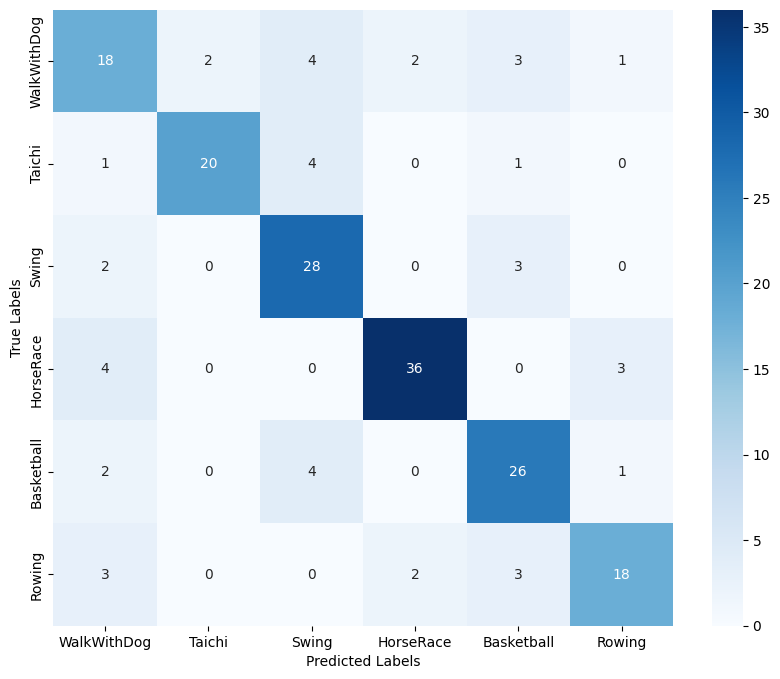

In [27]:
# Visualize the confusion_matrix of convlstm.
plt.figure(figsize=(10,8))
x_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
y_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
sn.heatmap(data = cm, annot = True, cmap = 'Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [28]:
label_names = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

 WalkWithDog       0.60      0.60      0.60        30
      Taichi       0.91      0.77      0.83        26
       Swing       0.70      0.85      0.77        33
   HorseRace       0.90      0.84      0.87        43
  Basketball       0.72      0.79      0.75        33
      Rowing       0.78      0.69      0.73        26

    accuracy                           0.76       191
   macro avg       0.77      0.76      0.76       191
weighted avg       0.77      0.76      0.77       191



LRCN MODEL

In [29]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [30]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 20, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 4, 4, 32)     

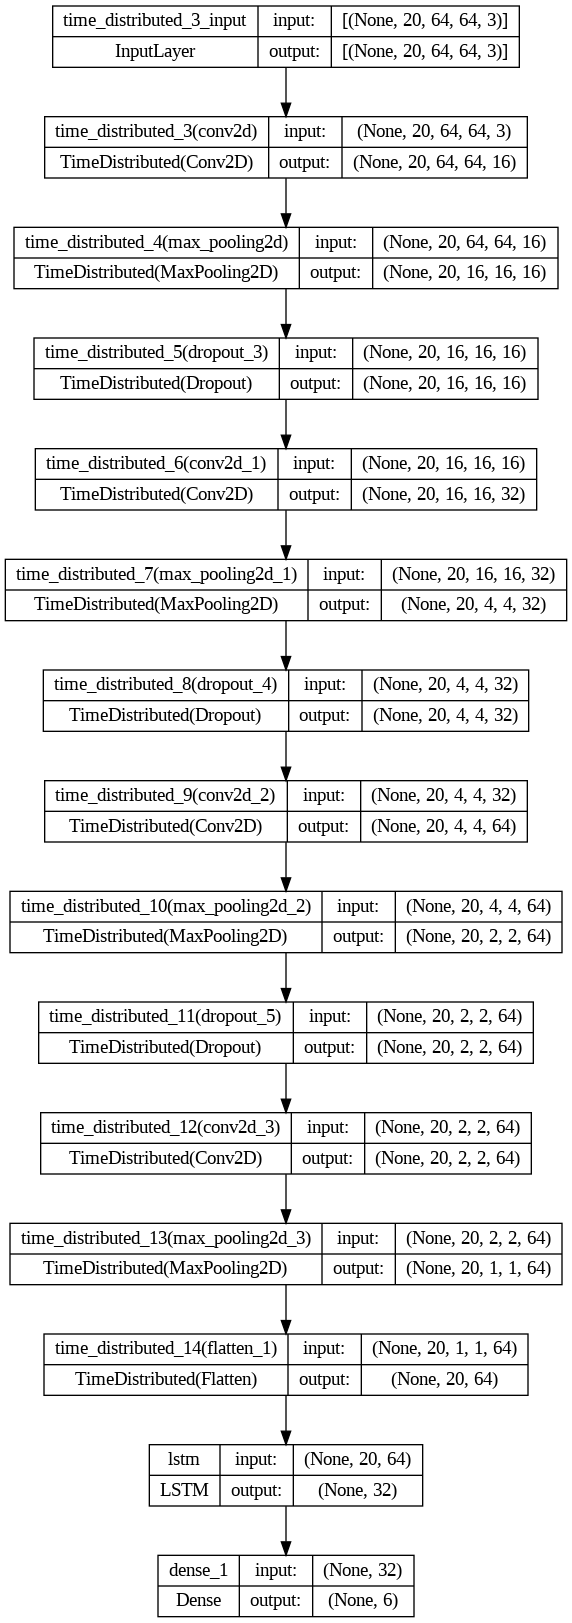

In [31]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [32]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
114/114 [==============================] - 7s 25ms/step - loss: 1.7963 - accuracy: 0.1732 - val_loss: 1.7394 - val_accuracy: 0.2895
Epoch 2/70
114/114 [==============================] - 1s 10ms/step - loss: 1.7329 - accuracy: 0.3026 - val_loss: 1.6604 - val_accuracy: 0.3333
Epoch 3/70
114/114 [==============================] - 1s 10ms/step - loss: 1.6337 - accuracy: 0.2961 - val_loss: 1.5085 - val_accuracy: 0.3947
Epoch 4/70
114/114 [==============================] - 1s 11ms/step - loss: 1.4690 - accuracy: 0.4145 - val_loss: 1.3634 - val_accuracy: 0.4825
Epoch 5/70
114/114 [==============================] - 1s 10ms/step - loss: 1.3527 - accuracy: 0.4846 - val_loss: 1.1280 - val_accuracy: 0.5614
Epoch 6/70
114/114 [==============================] - 1s 10ms/step - loss: 1.2022 - accuracy: 0.5702 - val_loss: 1.5402 - val_accuracy: 0.4211
Epoch 7/70
114/114 [==============================] - 1s 10ms/step - loss: 1.0295 - accuracy: 0.6272 - val_loss: 0.9238 - val_accuracy: 0.6579

In [33]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 [==============================] - 1s 90ms/step - loss: 0.3164 - accuracy: 0.9215


In [34]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

  saving_api.save_model(



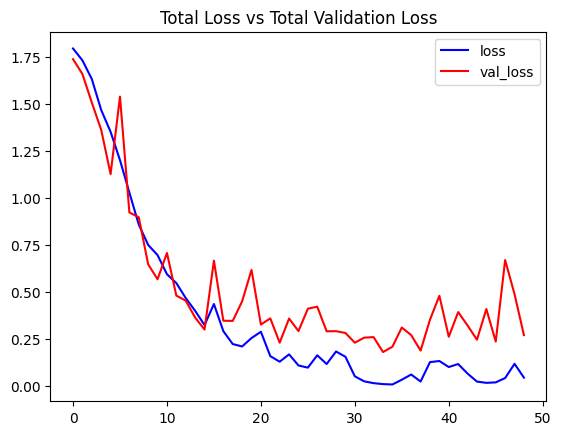

In [35]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

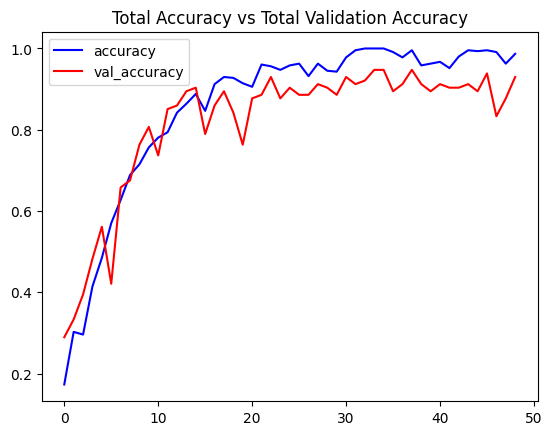

In [36]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Confusion Matrix

In [37]:
# Evaluate the confusion_marix.
LRCN_model.predict(np.expand_dims(features_test[0], axis=0)).round(2)

1/1 [==============================] - 1s 922ms/step


array([[0., 0., 1., 0., 0., 0.]], dtype=float32)

In [38]:
y_test=np.argmax(labels_test,axis=-1)

In [39]:
labels_test[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [40]:
# predict the features_test data
y_pred = np.argmax(LRCN_model.predict(features_test),axis=1)
y_pred

6/6 [==============================] - 0s 20ms/step


array([2, 3, 1, 3, 2, 5, 0, 2, 4, 5, 4, 4, 0, 0, 3, 5, 2, 3, 0, 5, 3, 3,
       3, 2, 2, 3, 2, 3, 4, 3, 0, 0, 2, 2, 5, 0, 1, 1, 4, 5, 1, 3, 3, 0,
       3, 3, 2, 0, 5, 0, 3, 2, 2, 5, 3, 4, 5, 3, 2, 0, 2, 0, 1, 1, 2, 4,
       3, 1, 3, 2, 4, 2, 1, 1, 0, 4, 0, 3, 0, 1, 4, 4, 4, 5, 0, 2, 4, 0,
       4, 2, 1, 1, 2, 0, 2, 3, 5, 1, 3, 4, 3, 4, 1, 5, 2, 0, 5, 3, 5, 0,
       0, 2, 4, 2, 2, 4, 1, 4, 3, 2, 1, 1, 1, 3, 2, 4, 2, 3, 4, 2, 3, 0,
       1, 5, 3, 4, 0, 5, 4, 3, 4, 1, 5, 1, 2, 4, 1, 2, 3, 4, 2, 5, 3, 3,
       5, 1, 5, 5, 3, 0, 0, 4, 5, 1, 3, 1, 3, 5, 1, 3, 3, 2, 5, 2, 0, 0,
       1, 4, 4, 5, 3, 3, 4, 3, 5, 2, 0, 3, 2, 0, 5])

In [41]:
# Display the Acuuracy
print('Accuracy score :', accuracy_score(y_test, y_pred))

Accuracy score : 0.9214659685863874


In [42]:
# Plot the confusion_matrix of convlstm.
plt.figure(figsize=(16,9))
y_pred_labels = [np.argmax(label) for label in y_pred ]
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix


<Figure size 1600x900 with 0 Axes>

Text(0.5, 58.7222222222222, 'Predicted Labels')

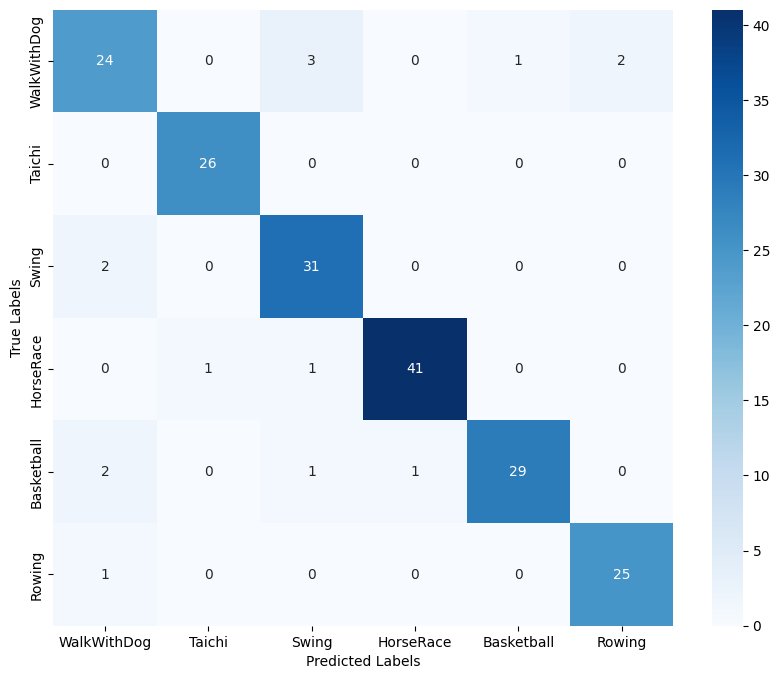

In [43]:
# Visualize the confusion_matrix of convlstm.
plt.figure(figsize=(10,8))
x_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
y_axis_labels = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
sn.heatmap(data = cm, annot = True, cmap = 'Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

In [44]:
label_names = ['WalkWithDog', 'Taichi', 'Swing', 'HorseRace','Basketball','Rowing']
print(classification_report(y_test, y_pred,target_names=label_names))

              precision    recall  f1-score   support

 WalkWithDog       0.83      0.80      0.81        30
      Taichi       0.96      1.00      0.98        26
       Swing       0.86      0.94      0.90        33
   HorseRace       0.98      0.95      0.96        43
  Basketball       0.97      0.88      0.92        33
      Rowing       0.93      0.96      0.94        26

    accuracy                           0.92       191
   macro avg       0.92      0.92      0.92       191
weighted avg       0.92      0.92      0.92       191



OUTPUT

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''

     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)

     # Retrieve the title of the video.
     title = video.title

     # Get the best available quality object for the video.
     video_best = video.getbest()

     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'

     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)

     # Return the video title.
     return title

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=IkUFkSMllW8', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]



        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 754/770 [00:01<00:00, 477.02it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/Multiple Actions-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 769/770, at time 27.87/27.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 770/770 [00:01<00:00, 476.67it/s]


In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

In [ ]:
# Download the youtube video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=6l_jEP3r3bc', test_videos_directory)

# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()


1/1 [==============================] - 0s 31ms/step
Action Predicted: WalkingWithDog
Confidence: 0.8430576324462891


 88%|████████▊ | 184/208 [00:00<00:00, 451.91it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/v WalkingWithDog g09 c01.mp4, 360000 bytes wanted but 0 bytes read,at frame 206/208, at time 6.87/6.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 208/208 [00:00<00:00, 445.61it/s]
